In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
from heatmap import heatmap, corrplot
import sctop as top

In [2]:
sns.set(context='talk', color_codes=True, palette='deep', style='whitegrid',
        rc={'mathtext.fontset': 'cm', 'xtick.direction': 'in','ytick.direction': 'in',
            'axes.linewidth': 1.5, 'figure.dpi':300, 'text.usetex':False}) 

In [3]:
def load(basis_name, minimum_cells = 100):
    source_dir = '../sctop/databases/'
    data = pd.read_hdf(source_dir + 'data_' + basis_name + '.h5')
    metadata = pd.read_csv(source_dir + 'metadata_' + basis_name + '.csv', index_col=0)
    
    # if Mouse Cell Atlas, drop cultured mesenchymal and trophoblast stem cells
    # ALso drop embroynic cells, because we only want an adult basis
    if 'MC' in basis_name:
        exceptions = [exception for exception in data.columns 
                      if ('Trophoblast' in exception) or ('Cultured' in exception) or ('E14.5' in exception) or ('Embryonic' in exception)]
        data = data.drop(columns = exceptions)
        metadata = metadata.drop(index = exceptions)
        
    types_above_minimum = metadata['Cell Count'] > minimum_cells
    
    return (data.loc[:, types_above_minimum].dropna(axis=0), metadata.loc[types_above_minimum])

In [4]:
basis, basis_metadata = load('MC20_apr22')

In [5]:
rawdata_herriges = pd.read_csv('./21_01_06_herriges_with_week6_invivo.csv')
metadata_herriges = pd.read_csv('./herriges_metadata.csv')

# Michael's labels for each of the clusters
cluster_key = {'2':'AT1 and AT1-like',
               '4':'Ciliated',
               '6':'Basal',
               '7':'Gastric-like',
               '8':'Neuroendocrine',
               '0+':'AT2',
               '1+13':'Secretory',
               '3+14':'AT2-like'}

clusters = metadata_herriges['new_clustering.07.12.2021'].values
cluster_labels = [cluster_key[cluster] for cluster in clusters]
identity = metadata_herriges['orig.ident'].values

type_annotations = np.array(cluster_labels)

type_annotations[type_annotations == 'AT2'] = 'AT2 and AT2-like' 
type_annotations[type_annotations == 'AT2-like'] = 'AT2 and AT2-like' 

# Sources for each of the cells
source_annotations = []

for label in identity:
    if 'Transplant' in label:
        source_annotations += ['Transplant']
    elif 'Endogenous' in label:
        source_annotations += ['Endogenous']
    elif 'Control' in label:
        source_annotations += ['Control']
        
source_annotations = np.array(source_annotations)

# Remove random sections of the basis and see what happens

In [6]:
data_herriges = top.process(rawdata_herriges)
projections_herriges = top.score(basis, data_herriges)

In [145]:
# subset = np.logical_and(type_annotations!='AT1 and AT1-like', source_annotations=='Control')
# data = data_herriges.loc[:,subset]
data = data_herriges
focus_type = 'Lung AT1 Cell WK6-10 MC20'

scores_full = top.score(basis, data)

basis_random_75 = basis.sample(frac=0.75, axis='columns')
if focus_type not in basis_random_75.columns:
    basis_random_75 = pd.concat([basis_random_75, basis.loc[:,focus_type]], axis='columns')

basis_random_50 = basis.sample(frac=0.50, axis='columns')
if focus_type not in basis_random_50.columns:
    basis_random_50 = pd.concat([basis_random_50, basis.loc[:, focus_type]], axis='columns')
    
basis_random_25 = basis.sample(frac=0.25, axis='columns')
if focus_type not in basis_random_25.columns:
    basis_random_25 = pd.concat([basis_random_25, basis.loc[:,focus_type]], axis='columns')

scores_75 = top.score(basis_random_75, data)
scores_50 = top.score(basis_random_50, data)
scores_25 = top.score(basis_random_25, data)

scores_compare = pd.concat([scores_full.loc[focus_type],
                               scores_75.loc[focus_type],
                               scores_50.loc[focus_type],
                               scores_25.loc[focus_type]
                              ],
                              axis=1
                             )
scores_compare.loc['Percentage'] = ['100', '75', '50', '25']
scores_melted = pd.melt(scores_compare.T, id_vars = 'Percentage')


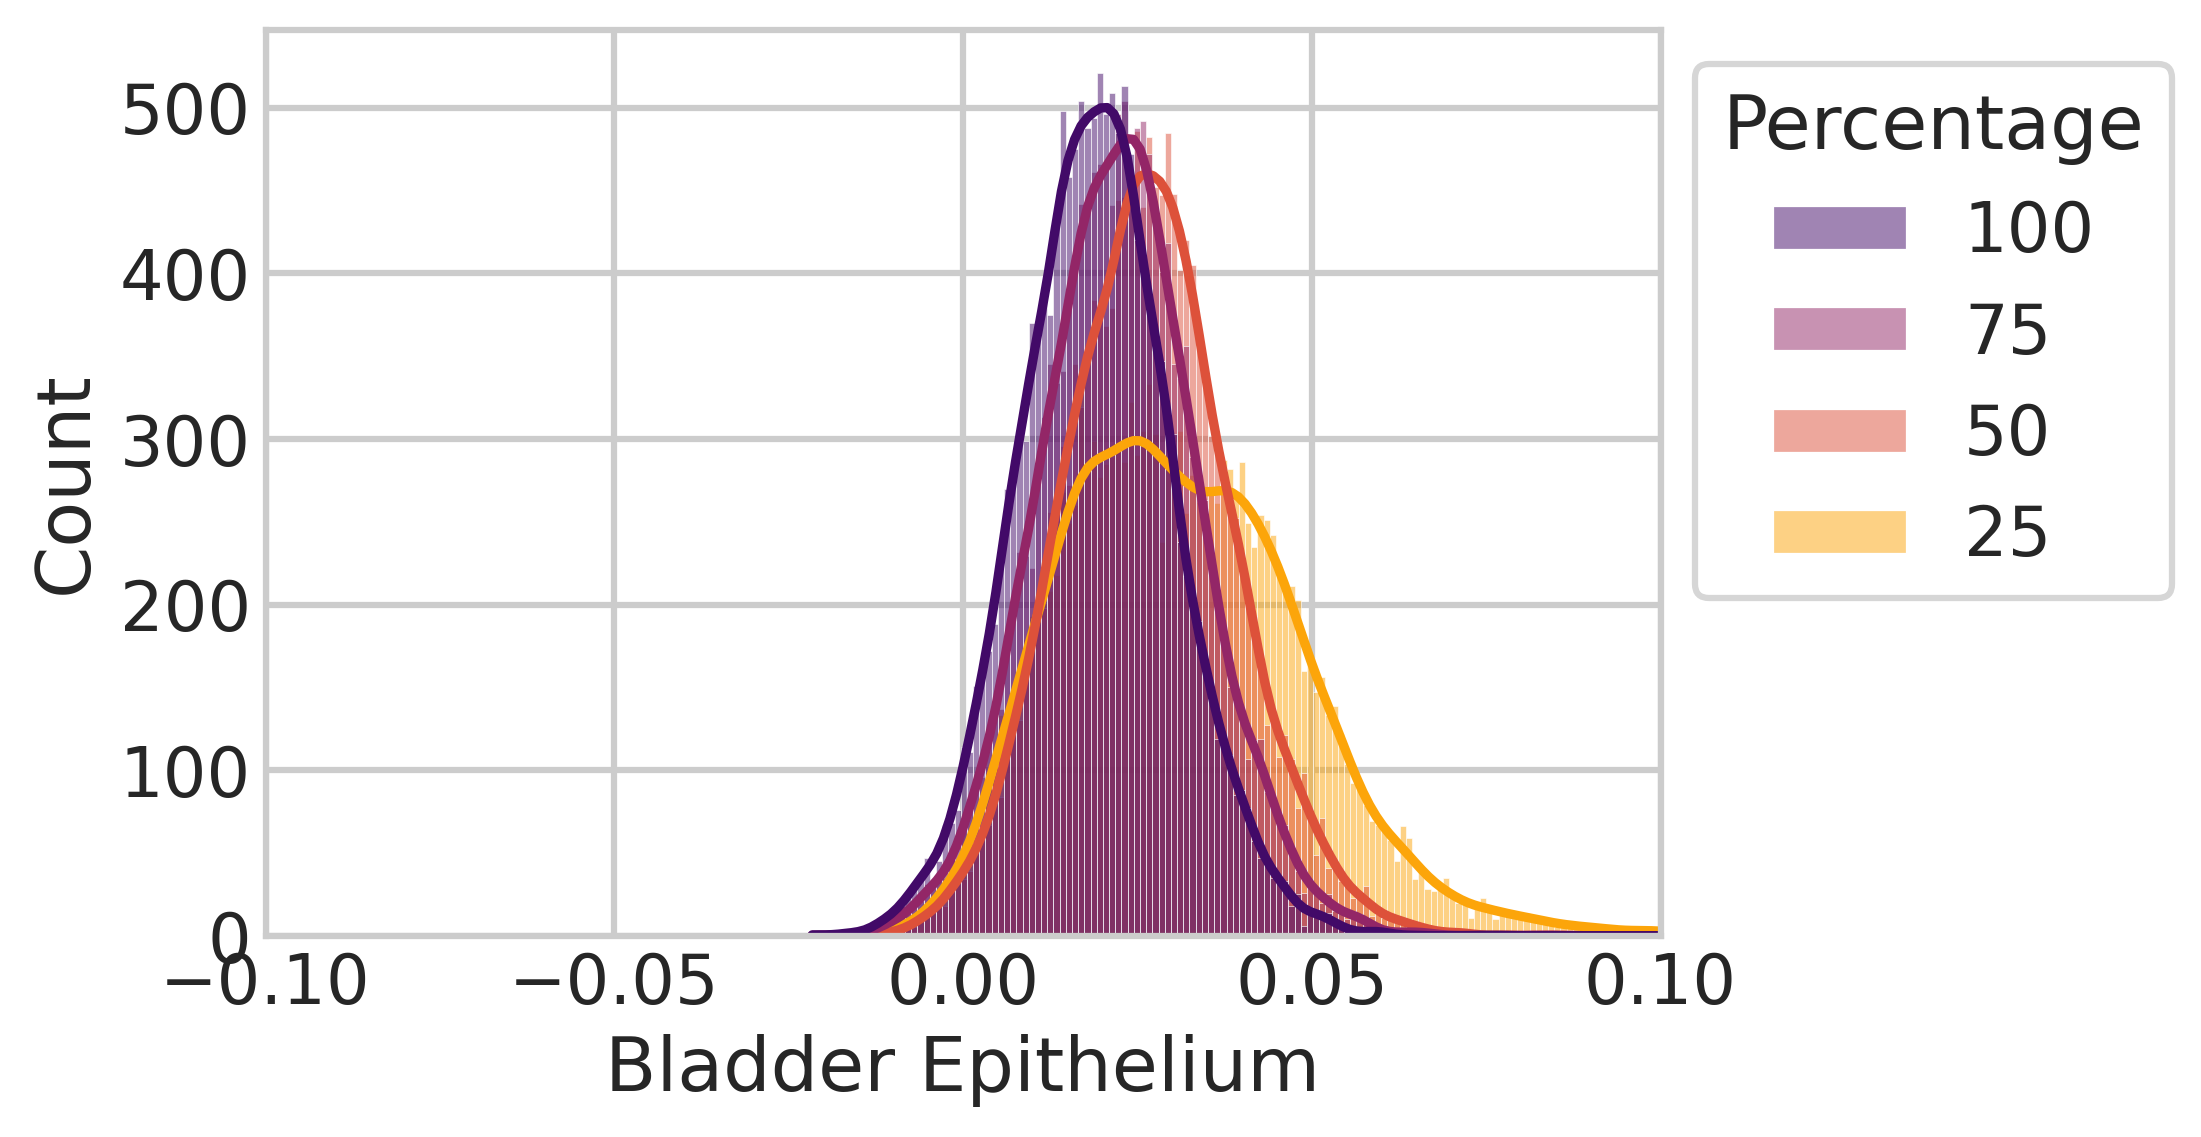

In [144]:
ax = sns.histplot(data=scores_melted, x="value", hue='Percentage', kde=True, palette='inferno')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xlabel('Bladder Epithelium')
plt.xlim([-0.1, 0.1])
plt.savefig("./manuscript figures/robust hist herriges all vs. bladder.pdf", transparent=True, bbox_inches = "tight")
plt.show()

In [7]:
# subset = np.logical_and(type_annotations!='AT1 and AT1-like', source_annotations=='Control')
# data = data_herriges.loc[:,subset]
data = data_herriges
focus_type = 'Lung AT2 Cell WK6-10 MC20'

scores_full = top.score(basis, data)

basis_lung = basis.loc[:,[col for col in basis.columns if 'Lung' in col]]
scores_lung = top.score(basis_lung, data)

basis_AT = basis.loc[:,[col for col in basis.columns if 'AT' in col]]
scores_AT = top.score(basis_AT, data)

scores_compare = pd.concat([scores_full.loc[focus_type],
                            scores_lung.loc[focus_type],
                            scores_AT.loc[focus_type]
                              ],
                              axis=1
                             )
scores_compare.loc['Basis types'] = ['Full', 'Lung', 'Lung Alveolar']
scores_melted = pd.melt(scores_compare.T, id_vars = 'Basis types')

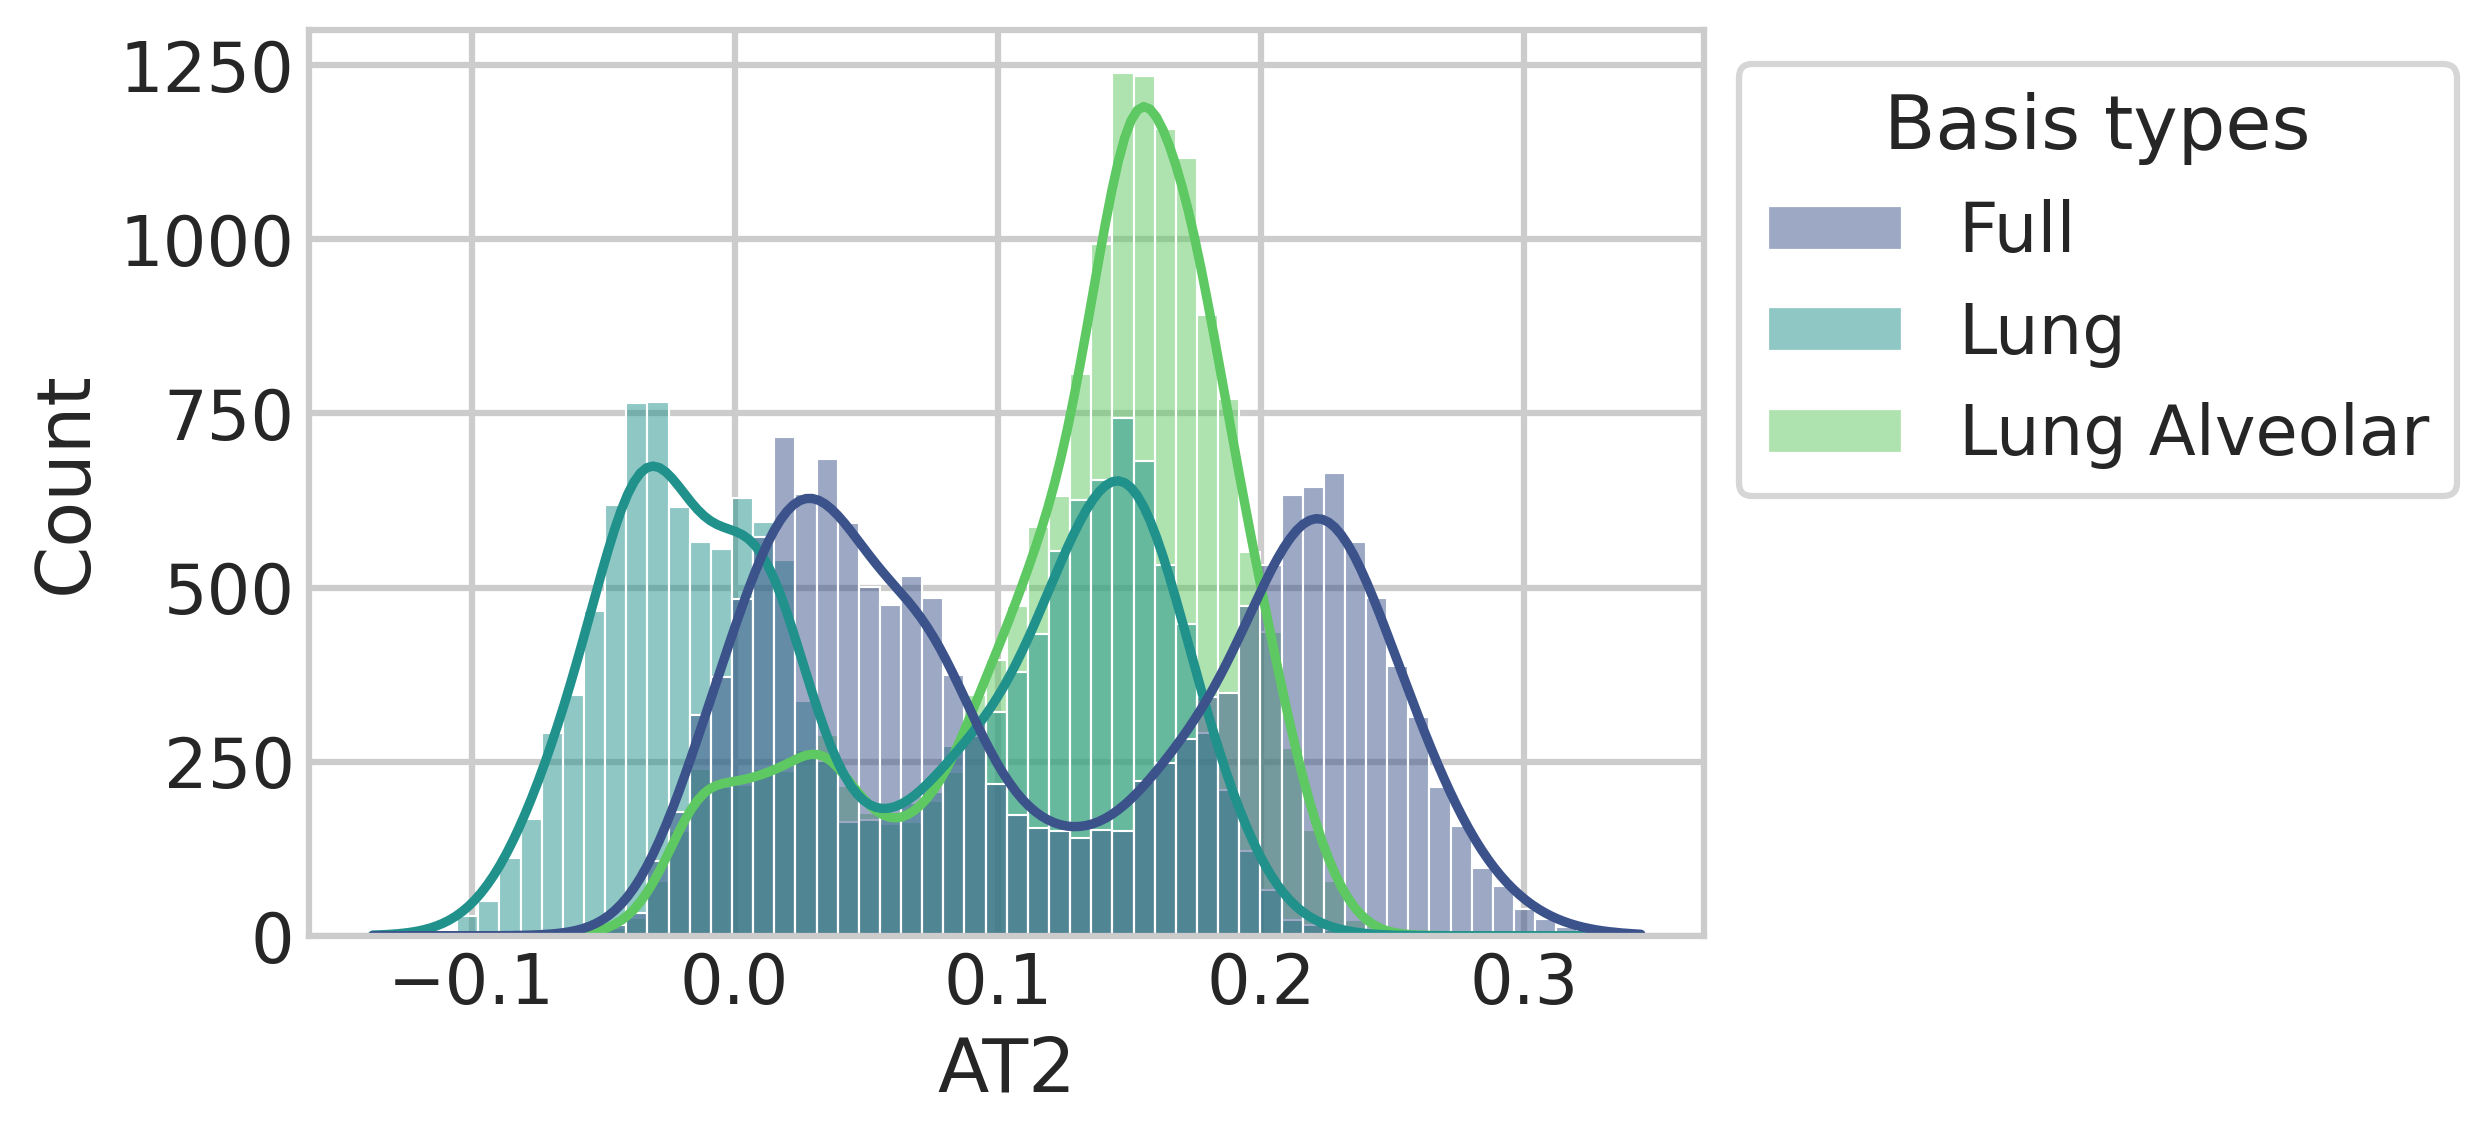

In [8]:
ax = sns.histplot(data=scores_melted, x="value", hue='Basis types', kde=True, palette='viridis')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xlabel('AT2')
plt.savefig("./manuscript figures/robust hist herriges all vs. at2 (by type).pdf", transparent=True, bbox_inches = "tight")
plt.show()